In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.convnext import preprocess_input
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import recall_score,precision_score,f1_score,confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/train_data",
    shuffle = True,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    seed=42,
    subset='training',
    # Use the training subset
)

validation_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/train_data",
    shuffle = False,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    seed=42,
    subset='validation'  # Use the validation subset
)

Found 9046 images belonging to 10 classes.
Found 1001 images belonging to 10 classes.


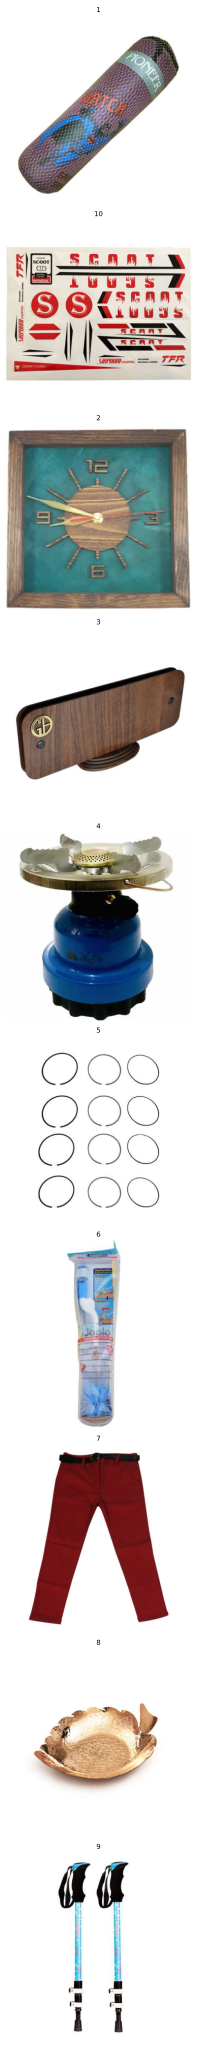

In [ ]:
fig = plt.figure(figsize=(100,50))
counter = 0
filenames = validation_generator.filenames
for class_name, class_index in validation_generator.class_indices.items():
    class_samples = [filename for filename in filenames if class_name in filename]
    sample_index = np.random.randint(0, len(class_samples))
    sample_filename = class_samples[sample_index]
    sample_image = plt.imread('/content/drive/MyDrive/train_data' + '/' + sample_filename)
    ax = fig.add_subplot(10,1,counter+1)
    ax.imshow(sample_image)
    ax.axis('off')
    ax.set_title(class_name)
    counter += 1
    if counter >= 10:
        break
plt.tight_layout()
plt.show()

In [4]:
model = keras.applications.ConvNeXtLarge(input_shape=(224,224,3),classes=10, weights="imagenet", include_top=False)
for layer in model.layers:
    layer.trainable = False
flatten = keras.layers.Flatten()(model.output)
xx=keras.layers.Dense(units=1000, activation='relu',kernel_regularizer=l2(1e-3))(flatten)
x = keras.layers.Dense(units=10, activation='softmax',kernel_regularizer=l2(1e-3))(xx)
model_cnxl = keras.models.Model(model.input, x)
model_cnxl.summary()

785596384/785596384 [==============================] - 10s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 convnext_large_prestem_nor  (None, 224, 224, 3)          0         ['input_1[0][0]']             
 malization (Normalization)                                                                       
                                                                                                  
 convnext_large_stem (Seque  (None, 56, 56, 192)          9792      ['convnext_large_prestem_norma
 ntial)                                                             lization[0][0]']              
                          

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.994718 to fit



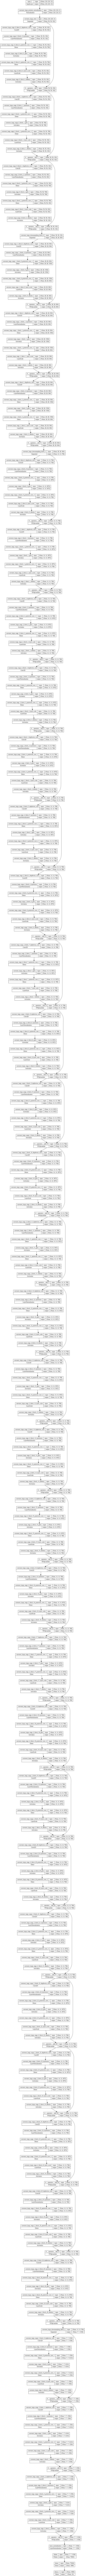

In [ ]:
keras.utils.plot_model(model_cnxl, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_cnxl.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1e-3),
              metrics='accuracy')

In [ ]:
lr_pl=ReduceLROnPlateau(monitor="val_accuracy",patience=3,min_delta=0.01,factor=0.05)
train_cnxl = model_cnxl.fit(train_generator,validation_data=validation_generator,epochs=20,callbacks=[lr_pl])

Epoch 1/20
566/566 [==============================] - 2237s 4s/step - loss: 3.6506 - accuracy: 0.5506 - val_loss: 3.1789 - val_accuracy: 0.6294 - lr: 0.0010
Epoch 2/20
566/566 [==============================] - 358s 631ms/step - loss: 2.8348 - accuracy: 0.6558 - val_loss: 2.7130 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 3/20
566/566 [==============================] - 357s 630ms/step - loss: 2.2620 - accuracy: 0.6951 - val_loss: 2.2814 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 4/20
566/566 [==============================] - 349s 616ms/step - loss: 1.9109 - accuracy: 0.7124 - val_loss: 1.9332 - val_accuracy: 0.6733 - lr: 0.0010
Epoch 5/20
566/566 [==============================] - 350s 618ms/step - loss: 1.7160 - accuracy: 0.7285 - val_loss: 1.9374 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 6/20
566/566 [==============================] - 364s 643ms/step - loss: 1.6052 - accuracy: 0.7359 - val_loss: 1.8665 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 7/20
566/566 [============================

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

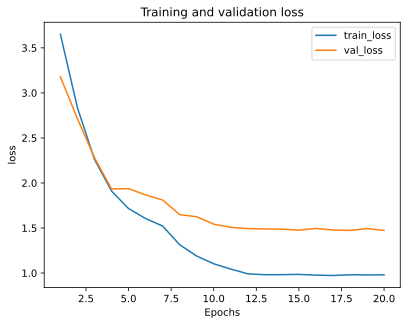

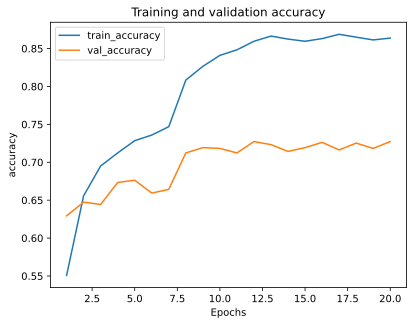

In [ ]:
plot_metric(train_cnxl , 'loss')
plot_metric(train_cnxl , 'accuracy')

In [ ]:
cnxl=model_cnxl.to_json()#
with open("/content/drive/MyDrive/ConvNeXtLarge_finall.json",'w') as json_file:
  json_file.write(cnxl)

model_cnxl.save_weights("/content/drive/MyDrive/ConvNeXtLarge_finall.h5")
print(":))))))))))")

:))))))))))


In [ ]:
train_cnxl.history['loss']

[3.650627613067627,
 2.8347854614257812,
 2.262019395828247,
 1.9108847379684448,
 1.7160428762435913,
 1.6052017211914062,
 1.521593451499939,
 1.3139803409576416,
 1.1886708736419678,
 1.1023616790771484,
 1.0440123081207275,
 0.9912669658660889,
 0.9812710881233215,
 0.9817664623260498,
 0.9849158525466919,
 0.9766650795936584,
 0.9726208448410034,
 0.9806640148162842,
 0.9791404604911804,
 0.9801800847053528]

In [ ]:
train_cnxl.history['val_loss']

[3.1788978576660156,
 2.7130255699157715,
 2.2813665866851807,
 1.9332340955734253,
 1.937398076057434,
 1.8665475845336914,
 1.810828685760498,
 1.6487541198730469,
 1.624837040901184,
 1.5429840087890625,
 1.5073769092559814,
 1.4934513568878174,
 1.4890179634094238,
 1.487035870552063,
 1.4758988618850708,
 1.4954516887664795,
 1.4777997732162476,
 1.472762942314148,
 1.4941248893737793,
 1.4736090898513794]

In [ ]:
train_cnxl.history['accuracy']

[0.5506300926208496,
 0.6557594537734985,
 0.6951138377189636,
 0.7123590707778931,
 0.7284987568855286,
 0.7359053492546082,
 0.7469599843025208,
 0.808423638343811,
 0.8265531659126282,
 0.8410347104072571,
 0.8483307361602783,
 0.8596064448356628,
 0.8664603233337402,
 0.862480640411377,
 0.8596064448356628,
 0.8631439208984375,
 0.8687818050384521,
 0.8650231957435608,
 0.8613752126693726,
 0.863807201385498]

In [ ]:
train_cnxl.history['val_accuracy']

[0.6293706297874451,
 0.6473526358604431,
 0.6443556547164917,
 0.6733266711235046,
 0.676323652267456,
 0.6593406796455383,
 0.6643356680870056,
 0.7122877240180969,
 0.7192807197570801,
 0.7182817459106445,
 0.7122877240180969,
 0.7272727489471436,
 0.7232767343521118,
 0.7142857313156128,
 0.7192807197570801,
 0.7262737154960632,
 0.7162837386131287,
 0.7252747416496277,
 0.7182817459106445,
 0.7272727489471436]

In [ ]:
y_pred=model_cnxl.predict(validation_generator)
val_lable=np.argmax(y_pred,axis=1)
val_true_labels = validation_generator.classes


63/63 [==============================] - 44s 520ms/step


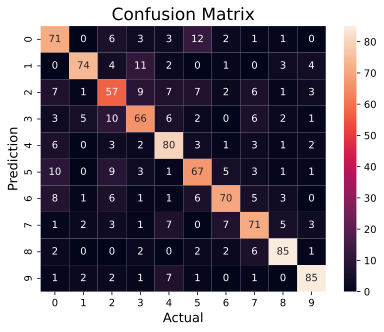

In [ ]:
import seaborn as sns
cm = confusion_matrix(val_true_labels,val_lable)
sns.heatmap(cm,
            annot=True,
            fmt='g', )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
f_score = f1_score(val_true_labels, val_lable, average='weighted')
f_score

0.7258008222766649

In [ ]:
recall= recall_score(val_true_labels, val_lable, average='weighted')
recall

0.7252747252747253

In [ ]:
precision= precision_score(val_true_labels, val_lable, average='weighted')
precision

0.7286530790890718

In [3]:
test_datagenerator = ImageDataGenerator(preprocessing_function=preprocess_input
                                        ,featurewise_center=True
                                        , featurewise_std_normalization=True)


test_generator=test_datagenerator.flow_from_directory(
    "/content/drive/MyDrive/test",
    target_size=(224,224),
    shuffle=False,
    batch_size=1,
    class_mode=None

)

Found 4010 images belonging to 1 classes.


In [6]:
model_cnxl.load_weights('/content/drive/MyDrive/ConvNeXtLarge_1.h5')

In [7]:
y_pred=model_cnxl.predict(test_generator)

4010/4010 [==============================] - 1395s 348ms/step


In [29]:
name=test_generator.filenames
label=np.argmax(y_pred,axis=1)+1

In [36]:
import pandas as pd
t=pd.DataFrame({'name':name,'label':label})
t.to_csv('test_1.csv')


In [38]:
t['label'].value_counts()

10    440
1     425
8     416
5     413
9     411
7     404
3     403
4     392
6     375
2     331
Name: label, dtype: int64